# Deep Learning Project2B - Part 2(Googlenet)
## Abdul Wahab Akram - 18L-1845

## Note: The data is already augmented like Part 1

## Major Imports

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import applications
from keras import backend as K
from keras.optimizers import SGD
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras import applications
import os
from os import listdir
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
import numpy as np

Using TensorFlow backend.


## Variables Inialization
### Image Width = 150
### Image Height = 150

In [0]:
train_data = []
train_labels = []
test_data = []
test_labels = []
im_width = 150
im_height = 150
num_classes = 7

## Preprocessing Function

In [ ]:
def preProcessTrainData(path):
    progress = 0
    image_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path,f))]
    
    for file_name in image_files:
        image_file = str(path + file_name)
        
        img = cv2.imread(image_file,cv2.IMREAD_COLOR)
        new_img = cv2.resize(img,(im_width,im_height))
        train_data.append(new_img)
        progress = progress+1
        
        train_labels.append(int(path[-2])-1)
        
        if progress%1000==0:
            print('Progress '+str(progress)+' Image done of Disease type:'  + path[-2])

## Preprocess images by calling preprocess function

In [4]:
for i in range(7):
    preProcessTrainData(os.getcwd()+'/DermCNN/'+str(i+1)+'/')

Progress 1000 Image done of Disease type:1
Progress 1000 Image done of Disease type:2
Progress 1000 Image done of Disease type:3
Progress 1000 Image done of Disease type:4
Progress 1000 Image done of Disease type:5
Progress 1000 Image done of Disease type:6
Progress 1000 Image done of Disease type:7


## Converting train_data list to numpy array

In [5]:
train_data = np.array(train_data)
#test_data = np.array(test_data)
print(train_data.shape)
#print(test_data.shape)

(11746, 150, 150, 3)


## Coverting train_labels list to numpy array

In [6]:
train_labels = np.array(train_labels)
#test_labels = np.array(test_labels)
train_labels.shape

(11746,)

## Reshaping data and converting it between 0 and 1

In [0]:
train_data = train_data.reshape((train_data.shape)[0],(train_data.shape)[1],(train_data.shape)[2],3)
train_data.astype('float32')
train_data = train_data/255.0

In [0]:
train_labels.astype('uint8')
train_labels = keras.utils.to_categorical(train_labels, num_classes)

## Function to shuffle data

In [0]:
def shuffle(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)



## Shuffling data and labels in unison

In [0]:
for i in range(10):
    shuffle(train_data,train_labels)
  #  shuffle(test_data,test_labels)

## Model 1

In [0]:
base_model = applications.InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(im_width, im_height,3))

In [12]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

## Freezing first 180 layers of Model 1 and fine-tuning the rest

In [0]:
for layer in base_model.layers[:180]:
   layer.trainable = False
for layer in base_model.layers[180:]:
   layer.trainable = True

## Adding custom dense layers along with softmax layer

In [0]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(200, activation='relu')(x)
x = Dropout(0.4)(x);
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

## Compile and fit Model 1 - Max Validation Accuracy Achieved = 83.33 at 49th epoch 

In [16]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(lr=0.001), metrics=["accuracy"])
history = model.fit(train_data, train_labels, validation_split=0.12, epochs=50, batch_size=30, verbose=1)

Train on 10336 samples, validate on 1410 samples
Epoch 1/50
10336/10336 [==============================] - 78s 8ms/step - loss: 0.4735 - acc: 0.8552 - val_loss: 3.7126 - val_acc: 0.5702
Epoch 2/50
10336/10336 [==============================] - 67s 7ms/step - loss: 0.1532 - acc: 0.9545 - val_loss: 0.9832 - val_acc: 0.7631
Epoch 3/50
10336/10336 [==============================] - 68s 7ms/step - loss: 0.1025 - acc: 0.9704 - val_loss: 1.8480 - val_acc: 0.6936
Epoch 4/50
10336/10336 [==============================] - 68s 7ms/step - loss: 0.0854 - acc: 0.9742 - val_loss: 2.3529 - val_acc: 0.6830
Epoch 5/50
10336/10336 [==============================] - 68s 7ms/step - loss: 0.0586 - acc: 0.9834 - val_loss: 1.1134 - val_acc: 0.7851
Epoch 6/50
10336/10336 [==============================] - 68s 7ms/step - loss: 0.0468 - acc: 0.9863 - val_loss: 0.8025 - val_acc: 0.8199
Epoch 7/50
10336/10336 [==============================] - 68s 7ms/step - loss: 0.0386 - acc: 0.9881 - val_loss: 1.3439 - val_acc:

## Epochs vs Loss Plot

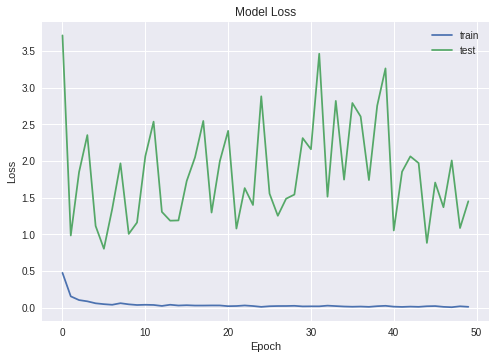

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Epochs vs Accuracy Plot

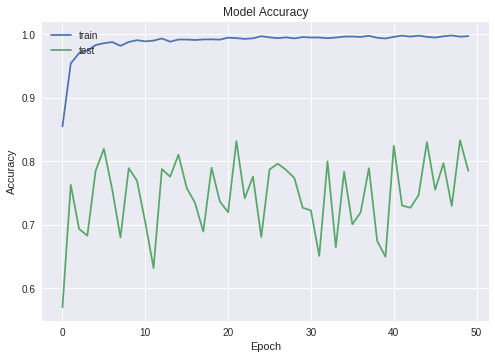

In [18]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model 2

In [0]:
base_model = applications.InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(im_width, im_height,3))

## Freezing first 100 layers of Model 2 and fine-tuning the rest

In [0]:
for layer in base_model.layers[:100]:
   layer.trainable = False
for layer in base_model.layers[100:]:
   layer.trainable = True

## Adding custom dense layers along with softmax layer

In [0]:
x = base_model.output
x = Dropout(0.3)(x);
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(200, activation='relu')(x)
x = Dropout(0.6)(x);
x = Dense(100, activation='relu')(x)
x = Dropout(0.4)(x);
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

## Compile and fit Model - Max Validation Accuracy achieved = 92.41 at 38th epoch

In [14]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(lr=0.0001), metrics=["accuracy"])
history = model.fit(train_data, train_labels, validation_split=0.12, epochs=50, batch_size=30, verbose=1)

Train on 10336 samples, validate on 1410 samples
Epoch 1/50
10336/10336 [==============================] - 99s 10ms/step - loss: 1.1844 - acc: 0.5702 - val_loss: 0.8810 - val_acc: 0.7035
Epoch 2/50
10336/10336 [==============================] - 84s 8ms/step - loss: 0.2851 - acc: 0.9164 - val_loss: 0.8689 - val_acc: 0.7837
Epoch 3/50
10336/10336 [==============================] - 85s 8ms/step - loss: 0.1508 - acc: 0.9598 - val_loss: 0.7818 - val_acc: 0.8262
Epoch 4/50
10336/10336 [==============================] - 85s 8ms/step - loss: 0.1067 - acc: 0.9711 - val_loss: 0.7502 - val_acc: 0.8149
Epoch 5/50
10336/10336 [==============================] - 84s 8ms/step - loss: 0.0605 - acc: 0.9837 - val_loss: 0.9454 - val_acc: 0.7681
Epoch 6/50
10336/10336 [==============================] - 85s 8ms/step - loss: 0.0746 - acc: 0.9826 - val_loss: 0.7040 - val_acc: 0.8355
Epoch 7/50
10336/10336 [==============================] - 85s 8ms/step - loss: 0.0595 - acc: 0.9860 - val_loss: 0.8597 - val_acc

## Epoch vs Loss Plot

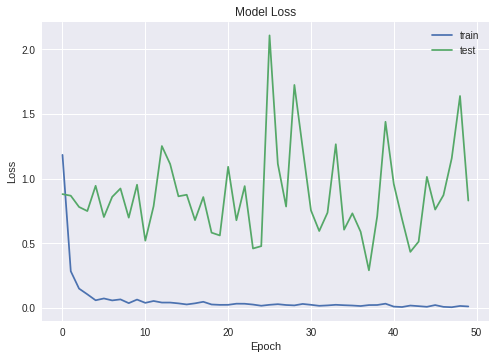

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Epoch vs Accuracy Plot

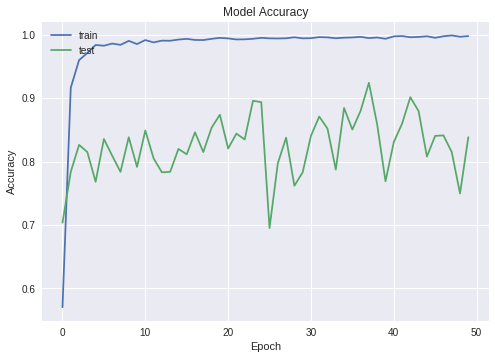

In [16]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()